# Synthea FHIR test

SyntheaTM Patient Generator

FHIR: Fast Healthcare Interoperability Resources. Web standard for health interop

CDS Hooks: Clinical Decision Support Hooks. Web standard for CDS in the EHR workflow

- https://github.com/synthetichealth/synthea
- https://github.com/smart-on-fhir/client-py
- http://docs.smarthealthit.org/client-py/
- http://docs.smarthealthit.org/
- https://github.com/AlgorexHealth/bmi-fhir/blob/master/FHIR%20BMI%20Results.ipynb
- https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-019-0793-0
- https://www.mitre.org/publications/project-stories/for-patient-data-synthea-is-the-missing-piece-in-health-it

```
conda create -n synthea-fhir python=3.8
conda activate synthea-fhir 
conda install git
conda install pip
conda install jupyter 
conda install ipykernel
conda install pandas
conda install pandas
conda install seaborn
conda install -c conda-forge altair vega_datasets

pip install fhirclient 
```

```
python -m ipykernel install --user --name synthea-fhir --display-name "SYNTHEA-FHIR"
```


In [32]:
import json
import fhirclient.models.bundle as b
import fhirclient.models.patient as p
import fhirclient.models.observation as o
from pathlib import Path
from decimal import *
import pandas as pd
import matplotlib
from datetime import date, timedelta, datetime
import csv
import altair as alt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# alt.renderers.enable('notebook')  
#    To use the 'notebook' renderer, you must install the vega package and the associated Jupyter extension.

%matplotlib inline

In ~/GitHub//GitHub/synthea
```
./run_synthea -p 1000
```


In [38]:
p = Path('data/fhir')
#p = Path('/Users/arvid/GitHub/synthea/output/fhir/run_synthea_p_1000_fhir')
#p = Path('/Users/arvid/GitHub/synthea/output/fhir')
files_to_load = [f for f in p.glob('*.json')]

if len(files_to_load) == 0:
    raise StopIteration("You don't have any FHIR files")
else:
    print("Loading {0} FHIR Files".format(len(files_to_load)))

Loading 2026 FHIR Files


We will also load as constants the CDC data tables that contain the percentile values for BMI at various ages.

In [39]:
def getBMITable(sex):
    if sex == 'M':
        file = 'data/male-2-20.csv'
    elif sex == 'F':
        file = 'data/female-2-20.csv'
    with open(file, 'r', encoding='utf-8-sig') as csvfile:
        reader = csv.DictReader(csvfile, quoting=csv.QUOTE_NONNUMERIC, fieldnames=['AgeMonths',3,5,10,25,50,75,85,90,95,97])
        bmi_table = [row for row in reader]
    return bmi_table

MALE_BMI_TABLE = getBMITable('M')
FEMALE_BMI_TABLE = getBMITable('F')

The functions below uses the SMART Python FHIR Client to parse the FHIR bundles and obtain the elements we will need:

- the patients date of birth
- their sex
- all of their BMI observations and the values

In [40]:
def getBMIObeservation(entry):
    if entry.resource.resource_type == 'Observation' and entry.resource.code.coding[0].code == '39156-5':
        return (entry.resource.effectiveDateTime.date, entry.resource.valueQuantity.value)
    else:
        return None

def getDateOfBirth(entry):
    if entry.resource.resource_type == 'Patient':
        return entry.resource.birthDate.date
    
def getSex(entry):
    if entry.resource.resource_type == 'Patient':
        return entry.resource.gender
    
def getAgeMonths(dob, visitdate):
    age_in_months = (visitdate.date()-dob)/timedelta(days=30.0)
    return age_in_months

Now we will tie all of this together as follows:

In [41]:
def getLatestBMI(bundle):
    # Find any obersvations with a BMI
    possible_visits_with_bmis = [getBMIObeservation(entry) for entry  in bundle.entry if getBMIObeservation(entry) ]
    if possible_visits_with_bmis:
        visit_date, bmi = max(possible_visits_with_bmis, key=lambda x:x[0]) # Get us the latest BMI
    else:
        return None #no possible BMIs 
    #Everyone's birthdate should be same but there is a possibility that this is notated several times in a FHIR bundle
    birthDate = max([getDateOfBirth(entry) for entry in bundle.entry if getDateOfBirth(entry) ])
    age = getAgeMonths(birthDate, visit_date) #uses the visit date from above
    if 24.0 < age > 240.0:
        return None #patients older than 20 and below 2 don't need  this measurementt
    sex = max([getSex(entry) for entry in bundle.entry if getSex(entry) ])
    if sex == 'male':
        bmi_table = MALE_BMI_TABLE
    else:
        bmi_table = FEMALE_BMI_TABLE
    
    age_row = min([row["AgeMonths"] for row in bmi_table if row["AgeMonths"] > age ])
    #Get their BMI from the CDC tables
    bmi_pct_row_values = ([row for row in bmi_table if row['AgeMonths'] == age_row][0]).copy()
    bmi_pct_row_values.pop('AgeMonths')
    bmi_pct_row_values[100] = 100 #this is the maximum case 
    pct = min([percentile for (percentile, bmi_value) in bmi_pct_row_values.items() if bmi <= bmi_value])
    
    
    return {'ageMonths':int(age),'BMI':bmi, 'BMIpct':pct, 'sex':sex}

Now for each file we have, we will run the functions we defined and save the results. This can take up to 2 minutes for all the files

In [42]:
bmi_results = []

for f_json in files_to_load:

    try:
        with open(f_json, 'r') as jsonfile:
            json_results = json.load(jsonfile)
    except:
        continue
    bundle = b.Bundle(json_results) 
    result = getLatestBMI(bundle)
    if result:
        bmi_results.append(result)

In [18]:
len(bmi_results)

1849

In [19]:
df = pd.DataFrame(bmi_results)
df.dtypes
df['ageYears'] = (df.ageMonths/12).astype(int)

In [20]:
# data_to_plot = df.sort_values('ageMonths').groupby(['ageMonths', 'sex']).agg({'BMI':np.mean, 'BMIpct':np.median})
data_to_plot = df.sort_values('ageMonths').reset_index()

The seaborn charts below plot the observed BMIs at the 10th, 25th, 50th, 75th, and 90th percentile. You can see the fitted polynomial regressions (which are smooth lines) start to appear a lot like the CDC growth chart.

(20.0, 250.0)

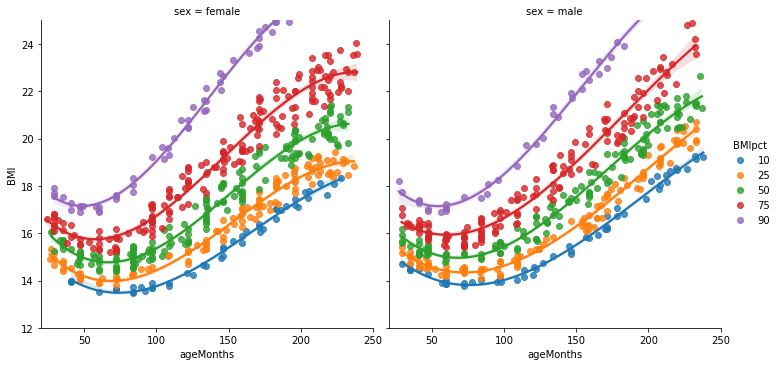

In [21]:
lm = sns.lmplot(data=data_to_plot[(data_to_plot.BMIpct.isin((10,25,50,75,90)) )], 
           x='ageMonths', y='BMI', hue='BMIpct', col='sex', order=3)

axes = lm.axes
axes[0,0].set_ylim(12,25)
axes[0,1].set_ylim(12,25)

axes[0,0].set_xlim(20,250)
axes[0,1].set_xlim(20,250)

Lastly, we can view our population averages across both sexes.

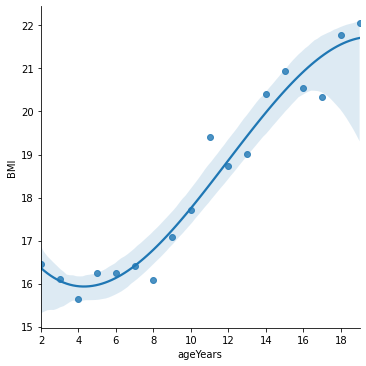

In [25]:
agg_data_to_plot = df.groupby('ageYears').mean().reset_index()
sns.lmplot(data=agg_data_to_plot, x='ageYears', y='BMI', order=3)
plt.show()